In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'

import numpy as np
import pandas as pd
from comut import comut
import scanpy as sc
import seaborn as sns
import warnings
import sys
import commentjson
sys.path.append(REPO)
import matplotlib.pyplot as plt
from settings import COLOR_PAlETTE
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Figure B: CoMut plot of sample characteristics

In [2]:
metadata = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
## genomic data
mutation_data = pd.read_csv(f'{RESULT_TABLE}/somatic_mutation.csv')
cnv_data = pd.read_csv(f'{RESULT_TABLE}/copy_number_alteration.csv')

### Comut plotting function

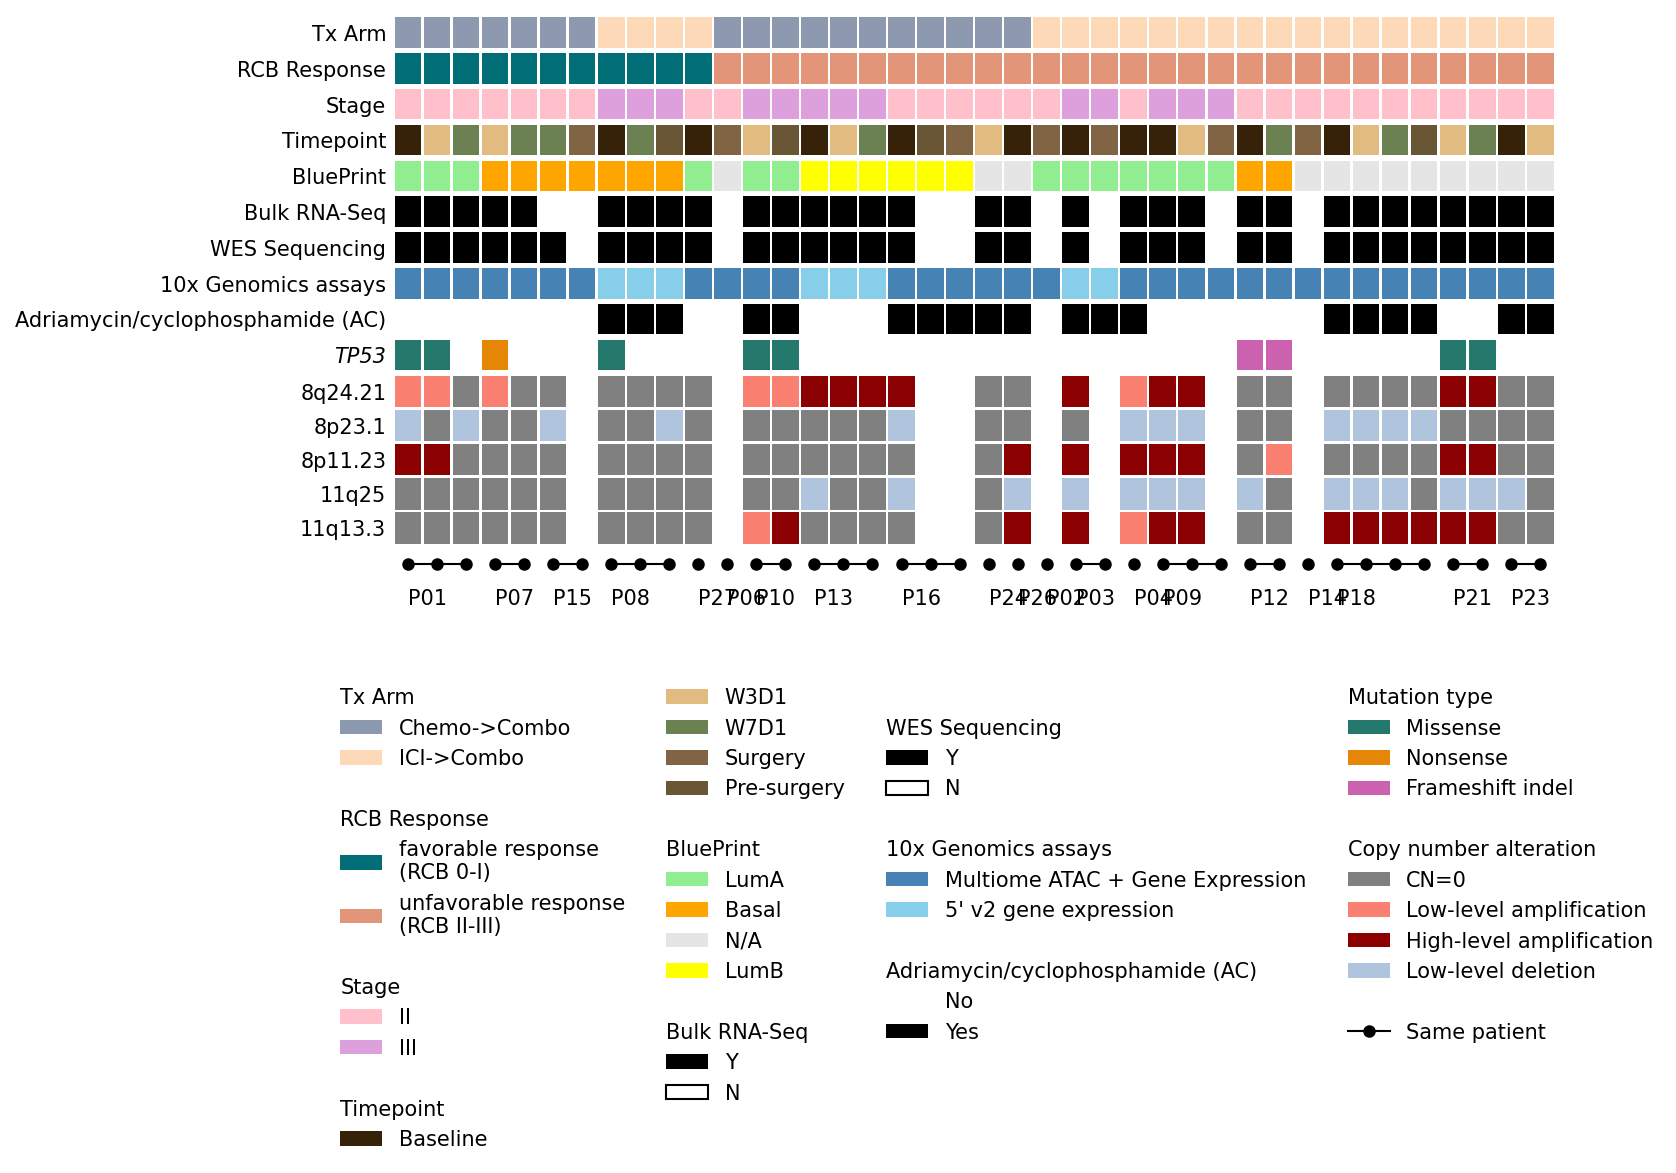

In [3]:
visual_category_columns = ['AC_Treatment','Tech','WES_Profile','BulkRNA_Profile','BluePrint','Timepoint','stage','BestResponse','Treatment_Arm']#Patient
Name_Map = {
    'WES_Profile':'WES Sequencing',
    'BulkRNA_Profile':'Bulk RNA-Seq',
    'Tech':'10x Genomics assays',
    'stage':'Stage',
    'Treatment_Arm':'Tx Arm',
    'BestResponse':'RCB Response',
    'AC_Treatment':'Adriamycin/cyclophosphamide (AC)'
}
comut_plot = comut.CoMut()
samples = metadata.sort_values(['BestResponse','Treatment_Arm']).index.tolist()
comut_plot.samples =samples
# Indicate same pt
metadata.reset_index(inplace=True)
indicator_df = metadata[['sample', 'Patient']].rename(columns={'Patient': 'group'})
indicator_df['group'] = indicator_df['group'].astype('category').cat.codes
indicator_kwargs = {
    'color': 'black',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 5,
}
comut_plot.add_sample_indicators(
    indicator_df.loc[indicator_df['sample'].isin(samples), :],
    name='Same patient',
    plot_kwargs=indicator_kwargs,
)
# add mutation data
name = 'Copy number alteration'
comut_plot.add_categorical_data(
    cnv_data,
    name=name,
    category_order=[ '11q13.3',
       '11q25',
       '8p11.23', '8p23.1', '8q24.21'],
    mapping=COLOR_PAlETTE[name],
)

name = 'Mutation type'
comut_plot.add_categorical_data(
    mutation_data,
    name=name,
    category_order=['TP53'],
    mapping=COLOR_PAlETTE[name],
    tick_style='italic',
)

#  add categorical data
for col_name in visual_category_columns:
    cat_df = metadata.melt(
        id_vars=['sample'], value_vars=[col_name], var_name='category'
    ).sort_values('value')
    name = Name_Map[col_name] if col_name in Name_Map else col_name
    cat_df['category'] = name
    comut_plot.add_categorical_data(
        cat_df, name=name, mapping=COLOR_PAlETTE[col_name]
    )
    

comut_plot.plot_comut(
    
    x_padding=0.04,
    y_padding=0.04,
    tri_padding=0.03,
    wspace=0.3,
    hspace=0.03,
    fig = plt.figure(figsize=(10, 5), tight_layout=False,dpi=150)
)
borders = ['N/A']
border_white = ['N']
pt_map = metadata.set_index('sample')['Patient'].to_dict()
pt_label_raw = [ pt_map[lb.get_text()] for lb in comut_plot.axes['Same patient'].get_xticklabels()]
seen=''
pt_label =[]
for l in pt_label_raw:
    if l==seen:
        pt_label.append('')
    else:
        pt_label.append(l)
    seen = l
comut_plot.axes['Same patient'].set_xticklabels(pt_label,rotation=0,ha='left',va='top')
# comut_plot.axes['Mutation type'].set_xticklabels([])
comut_plot.add_unified_legend(
    bbox_to_anchor=(1.1, -18), frameon=False, border_white=border_white,
    ncol=4
)  # ,borders=borders)

comut_plot.figure.savefig(f'{FIGURE_FOLDER}/Fig1B_Comut.svg', dpi = 200, bbox_inches = 'tight')

In [4]:
metadata['Timepoint'].value_counts()

Baseline       12
W3D1            9
W7D1            8
Surgery         7
Pre-surgery     4
Name: Timepoint, dtype: int64

## Figure C: UMAP representation of the entire cohort

### Gene expression

In [5]:
import scPipe as sp
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(f'{RESULT_TABLE}/GEX_OBS_Lineage.csv',index_col=0)
sample_meta =  pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
obs = obs.reset_index().merge(sample_meta,left_on='Sample',right_on='CCG_ID',how='left').set_index('index')
sc.pp.filter_genes(adata,min_cells=3) # consistent with the clustering method
sp.utils.attach_attr_from_pickle(data=adata,pickle_file=f'{RESULT_OBJ}/leiden_2000variable_genes/embeddings.pickle')
adata = adata[obs.index,:]
for c in ['Sample_Short','Timepoint','Treatment_Arm','Tech','Patient','Compartment']:
    adata.obs[c] = obs[c]

loading: obsm.X_umap
loading: obsm.X_diffmap
loading: obsm.X_tsne


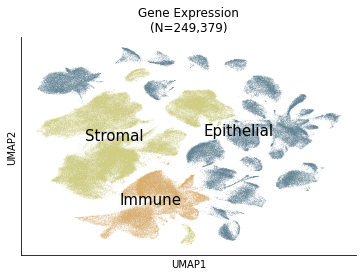

In [6]:
adata.obs['Compartment'] = pd.Categorical(adata.obs['Compartment'],['Epithelial', 'Immune', 'Stromal'])
adata.uns['Compartment_colors'] = ['#628395','#DBAD6A','#D0CE7C']
fig = sc.pl.umap(adata,color=['Compartment'],
           title=[f"Gene Expression\n(N={adata.shape[0]:,})"],
          legend_loc='on data',legend_fontweight='normal',legend_fontsize=15,
return_fig=True)
fig.savefig(f'{FIGURE_FOLDER}/UMAP/GEX_Broad_Celltype.png')

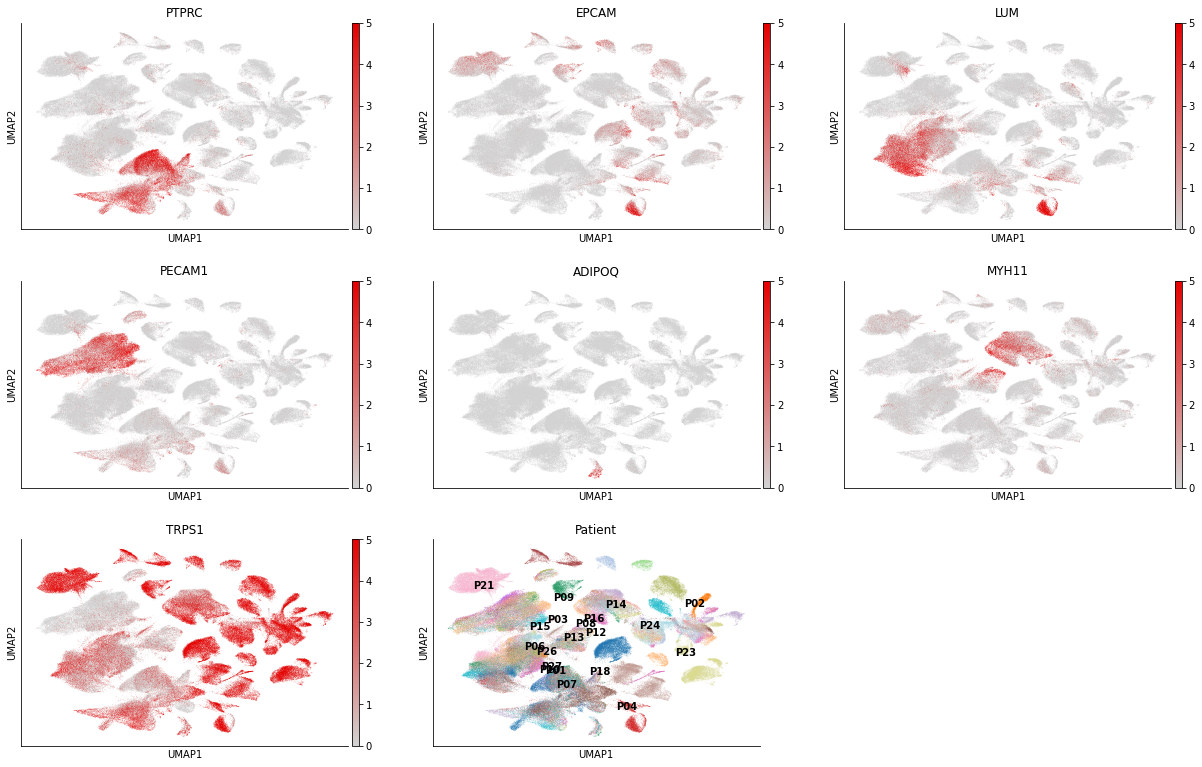

In [8]:
sc.pl.umap(adata,color=[
                        'PTPRC','EPCAM',"LUM","PECAM1","ADIPOQ","MYH11","TRPS1",'Patient'],
          cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["red"]], as_cmap=True),ncols=3,
          legend_loc='on data',vmin=0,vmax=5)

### ATAC

In [8]:
adata = sc.read(f'{RESULT_OBJ}/atac.h5ad')

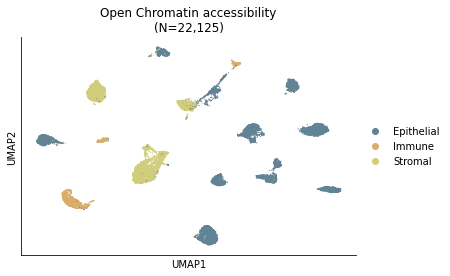

In [9]:
fig=sc.pl.umap(adata,color=['Compartment'],
           title=[f"Open Chromatin accessibility\n(N={adata.shape[0]:,})"],
               return_fig=True)
fig.savefig(f'{FIGURE_FOLDER}/UMAP/ATAC_Broad_Celltype.png')

## Figure D: Proportion of compartment in samples

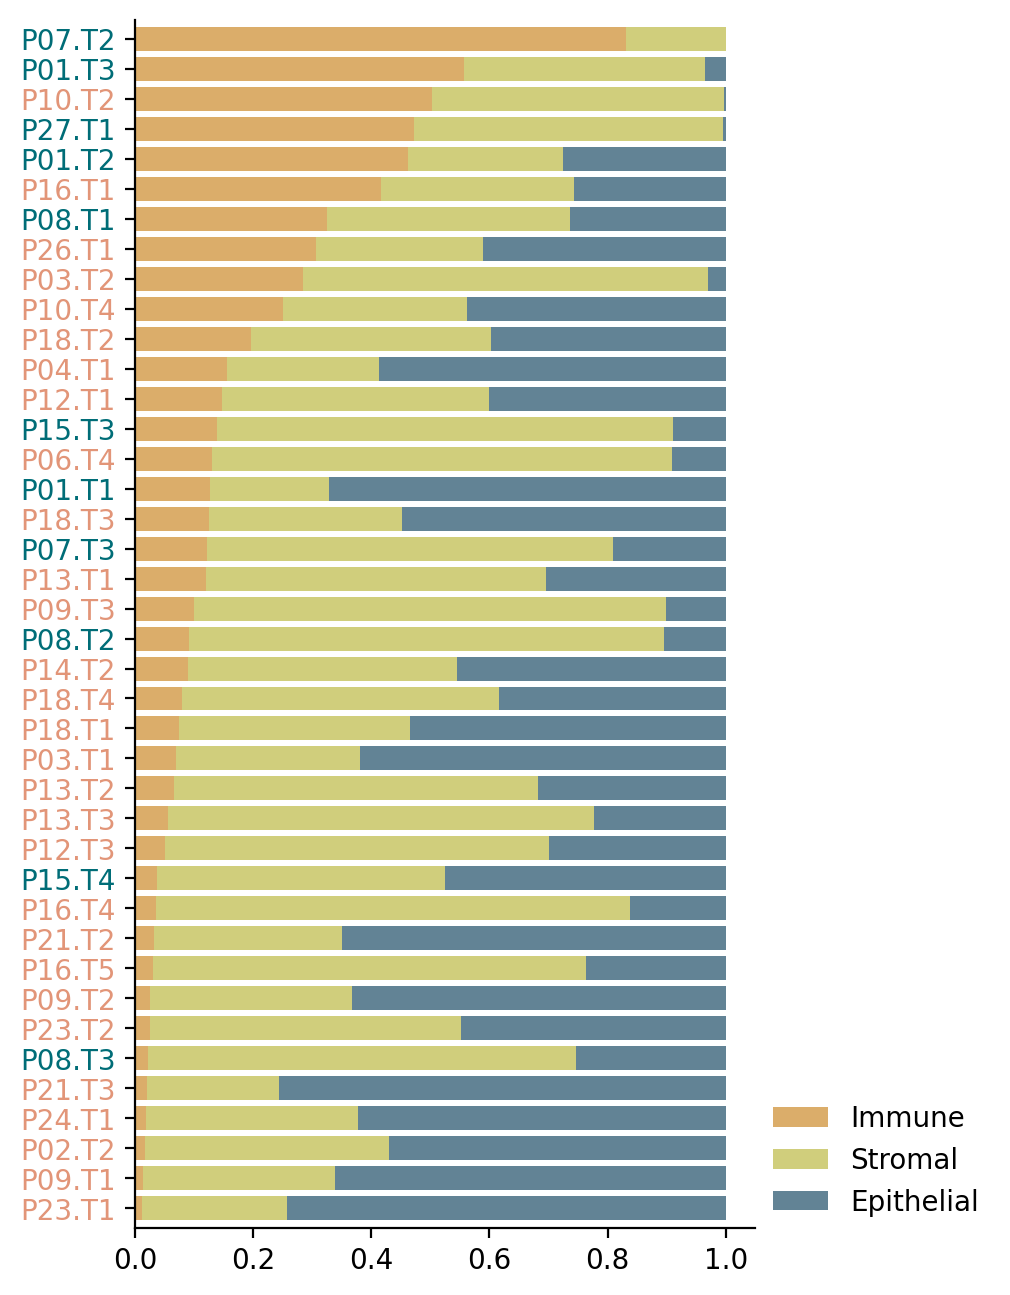

In [10]:
compartment_col = 'Compartment'
ordered_compartment = ['Immune','Stromal','Epithelial']
pt_bp_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['BestResponse'].to_dict()
# compartment percentage
pct = (pd.crosstab(obs[compartment_col],obs['Sample_Short']) / obs['Sample_Short'].value_counts()).T.sort_values(ordered_compartment)
pct = pct[ordered_compartment+[ x for x in pct.columns if not x in ordered_compartment ]]

fig,ax = plt.subplots(1,1,figsize=(4,8),dpi=200)
ax = pct.plot(kind='barh',stacked=True,color=COLOR_PAlETTE[compartment_col],width=.8,ax=ax)
ax.legend(loc=(1.01,0),frameon=False)
ax.set(ylabel='')
# ax.spines[['right','top','left']].set_visible(False)
for handle in ax.get_yticklabels():
    pt = handle.get_text()
    handle.set_color(COLOR_PAlETTE['BestResponse'][pt_bp_map[pt]])

fig.savefig(f'{FIGURE_FOLDER}/GEX_Broad_Celltype_Per_Sample.pdf')